In [1]:
import get_data as gd
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import Asset as a
import numpy as np
import random
from ta.momentum import RSIIndicator
import matplotlib.pyplot as plt

In [2]:
# set some hyperparameters
NUMBER_OF_GENERATION = 8
POPULATION_SIZE = 1000
MUTATION_PROBABILITY = 0.3
HIGHEST_WINDOWSIZE = 150
LOWEST_WINDOWSIZE = 8
HIGHEST_HIGHTHRESHOLD = 90
LOWEST_HIGHRESHOLD = 60
HIGHEST_LOWTHRESHOLD = 50
LOWEST_LOWTHRESHOLD = 15
MUTATION_HIGH = 1.5
MUTATION_LOW = 0.67

In [3]:
train_start_time = 0
train_end_time = int(0.8*718)
test_start_time = train_end_time + 1
test_end_time = 718

In [4]:
def create_population(size):
    population = []
    # generate population by random parameters(genes)
    for _ in range(size):
        windowsize = random.randint(LOWEST_WINDOWSIZE, HIGHEST_WINDOWSIZE)
        highthreshold = random.uniform(LOWEST_HIGHRESHOLD, HIGHEST_HIGHTHRESHOLD)
        lowthreshold = random.uniform(LOWEST_LOWTHRESHOLD, HIGHEST_LOWTHRESHOLD)
        individual = (windowsize, highthreshold, lowthreshold)
        population.append(individual)
    return population

In [5]:
def apply_strategy(data, individual, start_time, end_time):
    # initialize some variables
    windowsize, highthreshold, lowthreshold = individual
    rsi = RSIIndicator(data["close"], window=windowsize)
    data["rsi"] = rsi.rsi()
    btc = np.asarray(data["close"])
    asset = a.Asset()
    in_position = False
    money_progress = []
    
    # apply buy and sell strategy
    for i in range(start_time, end_time + 1):
        # buy
        if not in_position and data["rsi"].iloc[i] < lowthreshold:
            asset.buy(btc[i + 1])
            in_position = True
        # sell
        elif in_position and data["rsi"].iloc[i] > highthreshold:
            asset.sell(btc[i + 1])
            in_position = False
        # store the value of money in each iteration
        money_progress.append(asset.money + asset.coin * btc[i + 1])

    if in_position:
        asset.sell(btc[-1])

    money_progress.append(asset.money)

    return money_progress

# calculate fitness of each individual
def calculate_fitness(data, individual, start_time, end_time):
    money_progress = apply_strategy(data, individual, start_time, end_time)
    fitness = money_progress[-1] - 100
    # if fitness is negative, set it to 0
    return max(fitness, 0)

In [6]:
# calculate the probability of each individual and select them as the parents of next generation
def roulette_wheel_selection(population, fitness):
    total_fitness = sum(fitness)
    if total_fitness == 0:
        raise ValueError("The total fitness is 0, please try to run the program again.")
    probabilities = [f / total_fitness for f in fitness]
    selected_indices = np.random.choice(range(len(population)), size=2, replace=False, p=probabilities)
    return [population[i] for i in selected_indices]

In [7]:
# crossover the parents to generate children
def crossover(parents):
    child1, child2 = parents
    crossover_point = random.randint(1, 2)
    child1 = child1[:crossover_point] + child2[crossover_point:]
    child2 = child2[:crossover_point] + child1[crossover_point:]
    return child1, child2

In [8]:
# mutate the children
def mutation(child):
    # set some variables about mutation
    mutation_prob = MUTATION_PROBABILITY
    mutated_gene_index = random.randint(0, 2)
    mutation_factor = random.uniform(MUTATION_LOW, MUTATION_HIGH)
    
    child = list(child)
    # if the random number is smaller than mutation probability, mutate the child
    if random.random() < mutation_prob:
        # mutate the gene by multiplying the mutation factor
        child[mutated_gene_index] *= mutation_factor
        # restrict the value of the gene
        if mutated_gene_index == 0:
            child[mutated_gene_index] = max(min(HIGHEST_WINDOWSIZE, int(child[mutated_gene_index])), LOWEST_WINDOWSIZE)
        elif mutated_gene_index == 1:
            child[mutated_gene_index] = max(min(HIGHEST_HIGHTHRESHOLD, child[mutated_gene_index]), LOWEST_HIGHRESHOLD)
        else:
            child[mutated_gene_index] = max(min(HIGHEST_LOWTHRESHOLD, child[mutated_gene_index]), LOWEST_LOWTHRESHOLD)

    return tuple(child)

In [9]:
def draw_top_individuals(top_individuals, start_time, end_time):
    # plot the money progress of the top 4 individuals in last generation
    color_list = ['r', 'b', 'g', 'k']
    plt.figure(figsize=(8, 4))
    for idx, (individual, fit) in enumerate(top_individuals[:4]):
        days = range(start_time, end_time + 2)
        money_progress = apply_strategy(df_data, individual, start_time, end_time)
        plt.plot(days, money_progress, color=color_list[idx], label=f"Individual {idx + 1}: {individual}")
    plt.legend(loc='upper left')
    plt.title("Top 4 Individuals - Money Progress")
    plt.xlabel("Day")
    plt.ylabel("Money(AUD)")
    # plt.savefig("figure/Top4IndividualsMoneyProgress.png")
    plt.show()

In [10]:
def genetic_algorithm(data, start_time, end_time):
    # initialize the population
    population = create_population(POPULATION_SIZE)

    # run the algorithm for several generations
    for generation in range(NUMBER_OF_GENERATION):
        # calculate the fitness of each individual
        fitness = [calculate_fitness(data, individual, start_time, end_time) for individual in population]
        new_population = []

        # print the top 10 individuals and their fitness
        print(f"Generation {generation + 1}: Top 10 individuals and their fitness:")
        top_individuals = sorted(zip(population, fitness), key=lambda x: x[1], reverse=True)[:10]
        for individual, fit in top_individuals:
            print(f"Individual {individual} - Fitness: {fit:.2f}")
            
        draw_top_individuals(top_individuals, start_time, end_time)

        # generate new population by crossover and mutation
        while len(new_population) < POPULATION_SIZE:
            parents = roulette_wheel_selection(population, fitness)
            child1, child2 = crossover(parents)
            child1 = mutation(child1)
            child2 = mutation(child2)
            new_population.extend([child1, child2])

        population = new_population
    
    # return the top 10 individuals
    return top_individuals

Generation 1: Top 10 individuals and their fitness:
Individual (10, 61.561528389527204, 17.98608197456144) - Fitness: 81.53
Individual (13, 62.02784702361452, 23.595674202610475) - Fitness: 80.71
Individual (62, 64.61289654707774, 38.81789113505228) - Fitness: 35.79
Individual (140, 79.81316644715062, 42.88119203098742) - Fitness: 33.20
Individual (133, 77.77660904913427, 42.5500270426941) - Fitness: 33.20
Individual (39, 84.52461469375542, 32.68173074124243) - Fitness: 33.20
Individual (19, 73.13849508185731, 24.60079400059245) - Fitness: 33.20
Individual (100, 87.99315398340583, 40.916167792895834) - Fitness: 33.20
Individual (75, 60.64948513387857, 38.76101611428133) - Fitness: 33.20
Individual (57, 89.77125233920303, 36.472848270210754) - Fitness: 33.20


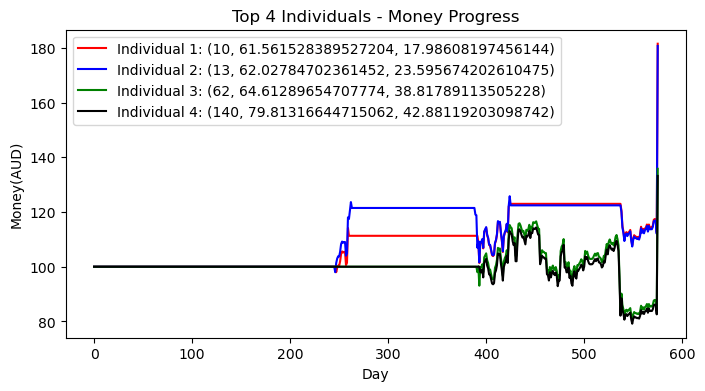

Generation 2: Top 10 individuals and their fitness:
Individual (10, 61.561528389527204, 17.98608197456144) - Fitness: 81.53
Individual (10, 61.561528389527204, 17.98608197456144) - Fitness: 81.53
Individual (10, 61.561528389527204, 17.98608197456144) - Fitness: 81.53
Individual (10, 61.561528389527204, 17.98608197456144) - Fitness: 81.53
Individual (10, 61.561528389527204, 17.98608197456144) - Fitness: 81.53
Individual (10, 61.561528389527204, 17.98608197456144) - Fitness: 81.53
Individual (10, 61.561528389527204, 17.98608197456144) - Fitness: 81.53
Individual (10, 61.561528389527204, 17.98608197456144) - Fitness: 81.53
Individual (10, 61.561528389527204, 17.98608197456144) - Fitness: 81.53
Individual (10, 61.561528389527204, 17.98608197456144) - Fitness: 81.53


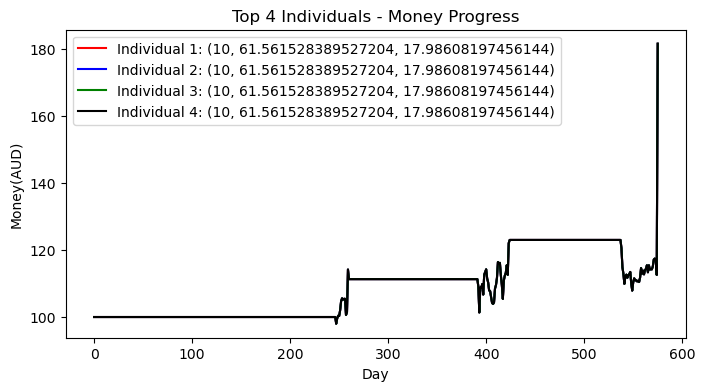

Generation 3: Top 10 individuals and their fitness:
Individual (13, 60, 22.640125934637055) - Fitness: 96.26
Individual (13, 62.02784702361452, 21.064253479811182) - Fitness: 90.29
Individual (10, 61.561528389527204, 17.98608197456144) - Fitness: 81.53
Individual (10, 61.561528389527204, 17.98608197456144) - Fitness: 81.53
Individual (10, 61.561528389527204, 17.98608197456144) - Fitness: 81.53
Individual (10, 61.561528389527204, 17.98608197456144) - Fitness: 81.53
Individual (10, 61.561528389527204, 17.98608197456144) - Fitness: 81.53
Individual (10, 61.561528389527204, 17.98608197456144) - Fitness: 81.53
Individual (10, 61.561528389527204, 17.98608197456144) - Fitness: 81.53
Individual (10, 61.561528389527204, 17.98608197456144) - Fitness: 81.53


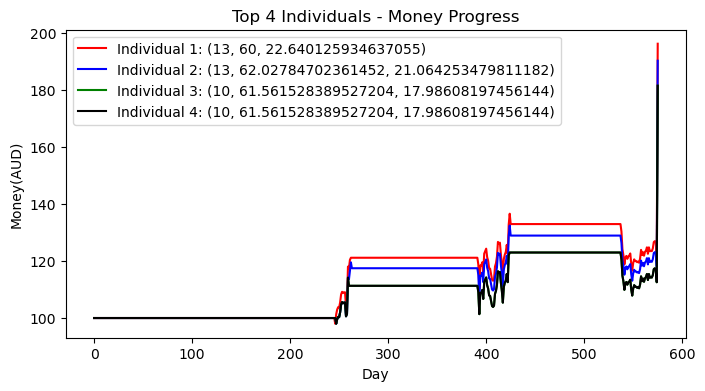

Generation 4: Top 10 individuals and their fitness:
Individual (13, 62.02784702361452, 21.861005905334128) - Fitness: 96.79
Individual (13, 60, 22.640125934637055) - Fitness: 96.26
Individual (13, 60, 22.640125934637055) - Fitness: 96.26
Individual (13, 60, 22.640125934637055) - Fitness: 96.26
Individual (13, 62.02784702361452, 21.064253479811182) - Fitness: 90.29
Individual (13, 60.907959329436345, 20.912253776446835) - Fitness: 89.78
Individual (10, 65.53295218875253, 17.98608197456144) - Fitness: 89.78
Individual (10, 65.79393867393756, 17.98608197456144) - Fitness: 89.78
Individual (10, 61.561528389527204, 17.98608197456144) - Fitness: 81.53
Individual (10, 61.561528389527204, 17.98608197456144) - Fitness: 81.53


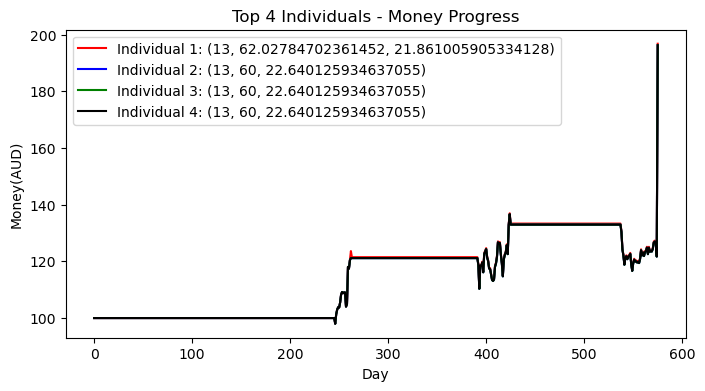

Generation 5: Top 10 individuals and their fitness:
Individual (13, 62.02784702361452, 23.230242238724323) - Fitness: 101.12
Individual (13, 62.02784702361452, 22.702336572280068) - Fitness: 96.79
Individual (14, 61.561528389527204, 23.595674202610475) - Fitness: 96.79
Individual (13, 62.02784702361452, 21.861005905334128) - Fitness: 96.79
Individual (13, 62.02784702361452, 21.861005905334128) - Fitness: 96.79
Individual (14, 60.907959329436345, 23.595674202610475) - Fitness: 96.79
Individual (13, 60, 22.640125934637055) - Fitness: 96.26
Individual (13, 60, 22.640125934637055) - Fitness: 96.26
Individual (13, 60.907959329436345, 22.105611009137256) - Fitness: 96.26
Individual (13, 60, 22.640125934637055) - Fitness: 96.26


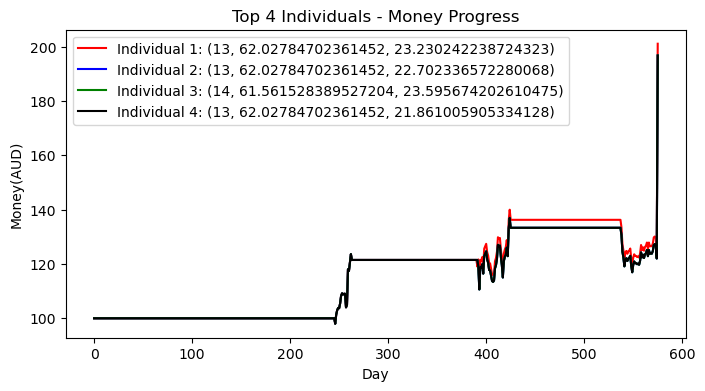

Generation 6: Top 10 individuals and their fitness:
Individual (13, 62.02784702361452, 23.265440914861912) - Fitness: 101.12
Individual (13, 62.02784702361452, 22.702336572280068) - Fitness: 96.79
Individual (13, 62.02784702361452, 22.702336572280068) - Fitness: 96.79
Individual (14, 60.907959329436345, 23.595674202610475) - Fitness: 96.79
Individual (13, 62.02784702361452, 22.105611009137256) - Fitness: 96.79
Individual (13, 62.02784702361452, 21.861005905334128) - Fitness: 96.79
Individual (13, 62.02784702361452, 21.861005905334128) - Fitness: 96.79
Individual (14, 60.907959329436345, 23.595674202610475) - Fitness: 96.79
Individual (14, 60.907959329436345, 23.595674202610475) - Fitness: 96.79
Individual (15, 60, 25.06748794361851) - Fitness: 96.79


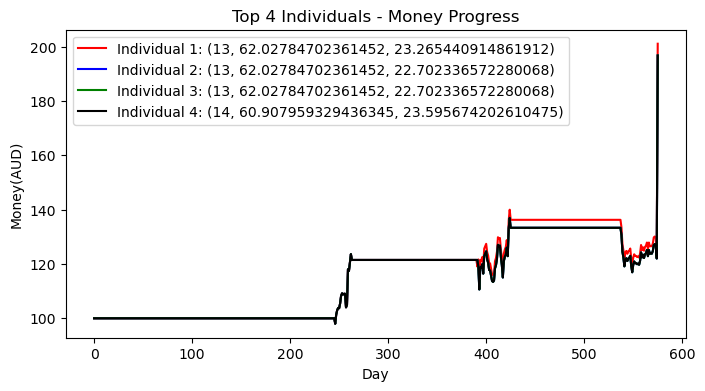

In [ ]:
df_data = gd.grab_data()
top_individuals = genetic_algorithm(df_data, train_start_time, train_end_time)

In [ ]:
# test
draw_top_individuals(top_individuals, test_start_time, test_end_time)